# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import copy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['ret_final'] = data.fillna(0)
#data['label'] = [(1 if j>0 else 0) for j in data.ret_final]
def find_label(curr_close, prev_close):
    if curr_close < (0.98 * prev_close):
        return 'label_down_200'
    elif (curr_close < (0.9825 * prev_close)) and (curr_close >= (0.98 * prev_close)):
        return 'label_static_down_175'
    elif (curr_close < (0.985 * prev_close)) and (curr_close >= (0.9825 * prev_close)):
        return 'label_static_down_150'
    elif (curr_close < (0.9875 * prev_close)) and (curr_close >= (0.985 * prev_close)):
        return 'label_static_down_125'
    elif (curr_close < (0.99 * prev_close)) and (curr_close >= (0.9875 * prev_close)):
        return 'label_static_down_100'
    elif (curr_close < (0.9925 * prev_close)) and (curr_close >= (0.99 * prev_close)):
        return 'label_static_down_75'
    elif (curr_close < (0.995 * prev_close)) and (curr_close >= (0.9925 * prev_close)):
        return 'label_static_down_50'
    elif (curr_close < (0.9975 * prev_close)) and (curr_close >= (0.995 * prev_close)):
        return 'label_static_down_25'
    elif (curr_close < prev_close) and (curr_close >= (0.9975 * prev_close)):
        return 'label_static_down_0'
    elif (curr_close >= prev_close) and (curr_close < (1.0025 * prev_close)):
        return 'label_static_up_0'
    elif (curr_close >= (1.0025 * prev_close)) and (curr_close < (1.005 * prev_close)):
        return 'label_static_up_25'
    elif (curr_close >= (1.005 * prev_close)) and (curr_close < (1.0075 * prev_close)):
        return 'label_static_up_50'
    elif (curr_close >= (1.0075 * prev_close)) and (curr_close < (1.01 * prev_close)):
        return 'label_static_up_75'
    elif (curr_close >= (1.01 * prev_close)) and (curr_close < (1.0125 * prev_close)):
        return 'label_static_up_100'
    elif (curr_close >= (1.0125 * prev_close)) and (curr_close < (1.015 * prev_close)):
        return 'label_static_up_125'
    elif (curr_close >= (1.015 * prev_close)) and (curr_close < (1.0175 * prev_close)):
        return 'label_static_up_150'
    elif (curr_close >= (1.0175 * prev_close)) and (curr_close < (1.02 * prev_close)):
        return 'label_static_up_175'
    elif curr_close > (1.02 * prev_close):
        return 'label_up_200'
    else:
        return 'Unknown'


data['label'] = ['label_down_200'] + [find_label(data.Close[i], data.Close[i-1]) for i in range(1,len(data.Close))] 
data = data[1:]
data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,ret_final,label
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.25,label_up_200
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.21,label_down_200
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.26,label_static_up_100
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.86,label_down_200
2008-10-22,13.91,14.46,13.28,13.84,536549400,0.0,-0.059,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.91,label_up_200


In [3]:
print('Unique Labels : ', data.label.unique())
print()
print('Label Counts : ', Counter(data.label))
print()
print('Label Distribution in Data')
for key, val in Counter(data.label).items():
    print('%25s : %.2f%%'%(key, val*100/data.shape[0]))

Unique Labels :  ['label_up_200' 'label_down_200' 'label_static_up_100'
 'label_static_up_125' 'label_static_down_175' 'label_static_down_50'
 'label_static_down_75' 'label_static_down_100' 'label_static_up_175'
 'label_static_up_25' 'label_static_up_50' 'label_static_down_150'
 'label_static_up_75' 'label_static_down_25' 'label_static_down_125'
 'label_static_up_0' 'label_static_up_150' 'label_static_down_0']

Label Counts :  Counter({'label_up_200': 262, 'label_down_200': 250, 'label_static_up_0': 227, 'label_static_down_0': 216, 'label_static_down_25': 212, 'label_static_up_50': 192, 'label_static_down_50': 184, 'label_static_up_25': 183, 'label_static_up_75': 154, 'label_static_up_100': 143, 'label_static_down_75': 134, 'label_static_up_125': 113, 'label_static_up_150': 102, 'label_static_down_100': 99, 'label_static_up_175': 87, 'label_static_down_125': 75, 'label_static_down_150': 69, 'label_static_down_175': 53})

Label Distribution in Data
             label_up_200 : 9.51%
    

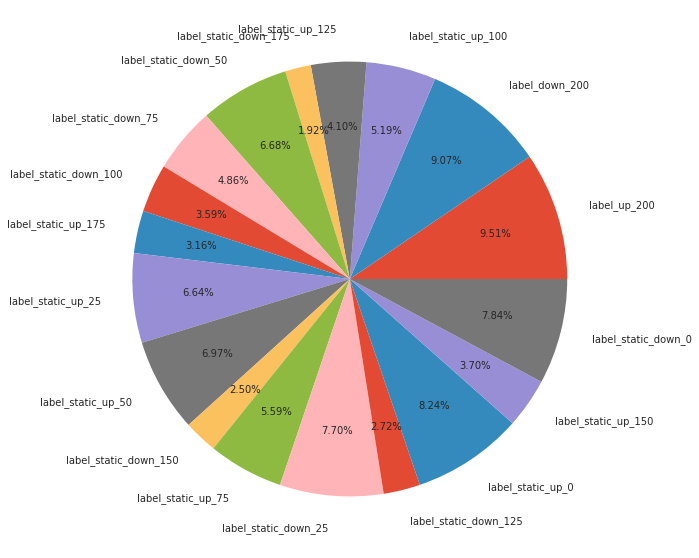

In [4]:
with plt.style.context(('seaborn','ggplot')):
    labels_dist = Counter(data.label)
    plt.figure(figsize=(10,10))
    plt.pie(x=labels_dist.values(), labels=labels_dist.keys(), autopct='%0.2f%%', pctdistance=0.7, radius=1.0, labeldistance=1.15)

In [5]:
encoder = LabelEncoder()
data['encoded_label'] = encoder.fit(data.label).transform(data.label)
labels_to_idx = dict(zip(encoder.classes_, range(len( encoder.classes_))))
labels_to_idx

{'label_down_200': 0,
 'label_static_down_0': 1,
 'label_static_down_100': 2,
 'label_static_down_125': 3,
 'label_static_down_150': 4,
 'label_static_down_175': 5,
 'label_static_down_25': 6,
 'label_static_down_50': 7,
 'label_static_down_75': 8,
 'label_static_up_0': 9,
 'label_static_up_100': 10,
 'label_static_up_125': 11,
 'label_static_up_150': 12,
 'label_static_up_175': 13,
 'label_static_up_25': 14,
 'label_static_up_50': 15,
 'label_static_up_75': 16,
 'label_up_200': 17}

# Exploratory Data Analysis

## Correlation Between Features and Label/Returns/Close Price/Open Price

Below we have found out correlation between all feaatures and label, returns, close price and open price. We'll use this correlation for plotting purpose below.

In [6]:
corr_between_features_and_label = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15','encoded_label']].corr()

In [7]:
corr_between_features_and_label

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,encoded_label
feature1,1.000,0.403,0.108,0.772,0.792,-0.172,-0.173,-0.128,0.473,0.530,0.473,0.718,0.354,0.303,0.256,0.383
feature2,0.403,1.000,0.015,0.280,0.353,-0.012,-0.002,-0.009,0.069,0.102,0.069,0.172,0.088,0.113,0.050,0.669
feature3,0.108,0.015,1.000,0.312,-0.052,0.145,0.161,0.117,0.377,0.372,0.377,0.052,0.168,0.031,0.163,-0.003
feature4,0.772,0.280,0.312,1.000,0.566,-0.218,-0.110,-0.191,0.807,0.844,0.807,0.557,0.417,0.207,0.356,0.267
feature5,0.792,0.353,-0.052,0.566,1.000,-0.052,-0.260,0.011,0.060,0.133,0.060,0.792,0.182,0.339,0.065,0.373
feature6,-0.172,-0.012,0.145,-0.218,-0.052,1.000,0.207,0.968,-0.286,-0.290,-0.286,-0.054,-0.160,0.007,-0.168,-0.024
feature7,-0.173,-0.002,0.161,-0.110,-0.260,0.207,1.000,-0.036,0.014,-0.002,0.014,-0.301,-0.177,-0.115,-0.142,-0.016
feature8,-0.128,-0.009,0.117,-0.191,0.011,0.968,-0.036,1.000,-0.290,-0.290,-0.290,0.019,-0.114,0.035,-0.131,-0.018
feature9,0.473,0.069,0.377,0.807,0.060,-0.286,0.014,-0.290,1.000,0.996,1.000,0.213,0.410,0.035,0.413,0.032
feature10,0.530,0.102,0.372,0.844,0.133,-0.290,-0.002,-0.290,0.996,1.000,0.996,0.268,0.421,0.061,0.414,0.068


Below bar charts show correlation value (Positive/Negative) between features and label, returns, close price and open price.

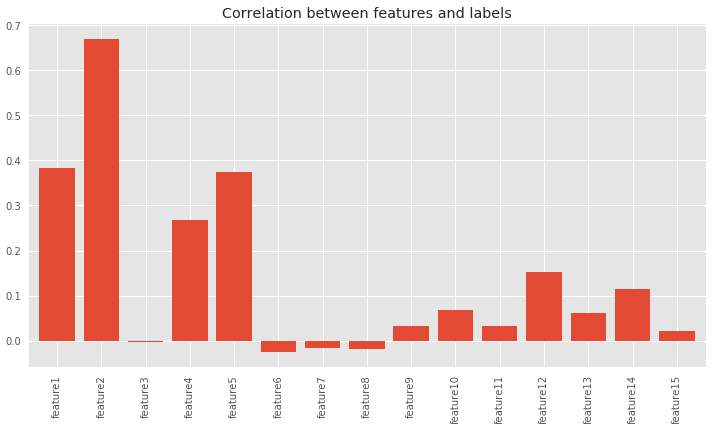

In [8]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(10,6))
    corr_between_features_and_label.loc['encoded_label',].drop('encoded_label').plot(kind='bar', width=0.8, title='Correlation between features and labels')
    
    plt.tight_layout()

Below heatmaps shows correlation between various features and label, returns and close price.

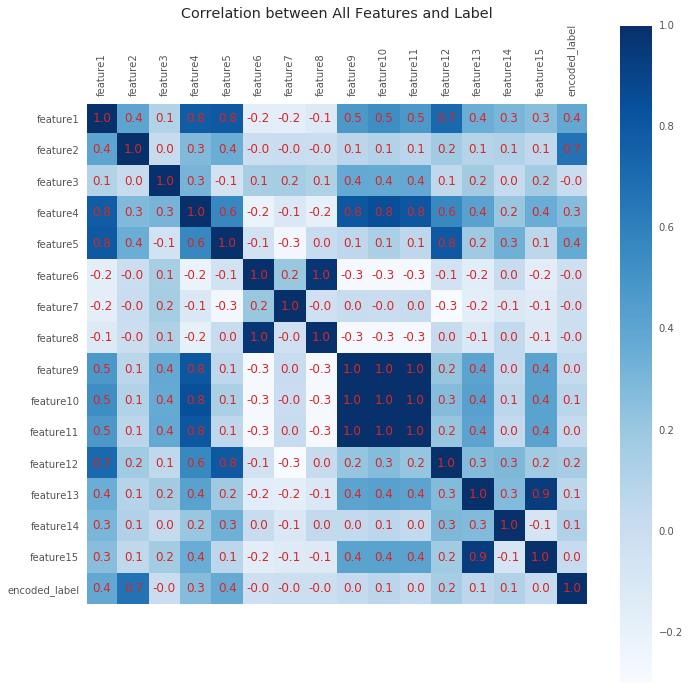

In [9]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=12);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=12);
                
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,10))
    plot_correlation_matrix(corr_between_features_and_label, 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

## P-value For Label, Returns and Close Price
Below we have plotted p-value and f-classif/f-regression values. Lower p-values generally indicates that that feature has high relation with target variable. Higher p-values incdicates that feature has less relation with target. You can compare this graph with above one.

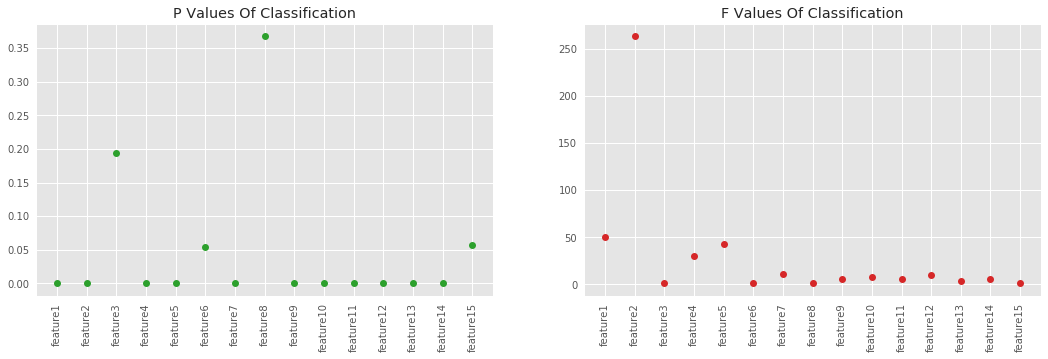

In [10]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,5))
    plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(122)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('F Values Of Classification');

# Dividing Data Into Train/Test Sets
We have selected 15 features are our main features for prediction and label column as predicting column. We'll divide dataset into `90%` for training and `10%` for test.

In [11]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values
Y_one_hot = np_utils.to_categorical(data['encoded_label'].values)
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)
X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)
print(sorted(Counter(Y_train).items(), key=lambda x : x[0]))
print(sorted(Counter(Y_test).items(), key=lambda x: x[0]))

Train/Test Sizes :  (2479, 15) (276, 15) (2479,) (276,)
Train/Test Sizes :  (2479, 15) (276, 15) (2479, 18) (276, 18)
Actual Return Sizes :  (276,)
[(0, 218), (1, 199), (2, 87), (3, 71), (4, 62), (5, 45), (6, 195), (7, 170), (8, 118), (9, 210), (10, 125), (11, 103), (12, 92), (13, 79), (14, 166), (15, 171), (16, 136), (17, 232)]
[(0, 32), (1, 17), (2, 12), (3, 4), (4, 7), (5, 8), (6, 17), (7, 14), (8, 16), (9, 17), (10, 18), (11, 10), (12, 10), (13, 8), (14, 17), (15, 21), (16, 18), (17, 30)]


### Sanity Checks

In [12]:
print('Cheking that train data has all classes covered for model to learn as well as check distribution for test')
print(set(Y_train), set(Y_test))
print()
print(np.bincount(Y_train)*100/Y_train.shape[0])
print(np.bincount(Y_test)*100/Y_test.shape[0])

Cheking that train data has all classes covered for model to learn as well as check distribution for test
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

[8.794 8.027 3.509 2.864 2.501 1.815 7.866 6.858 4.76  8.471 5.042 4.155
 3.711 3.187 6.696 6.898 5.486 9.359]
[11.594  6.159  4.348  1.449  2.536  2.899  6.159  5.072  5.797  6.159
  6.522  3.623  3.623  2.899  6.159  7.609  6.522 10.87 ]


### Finance Metrics
Below are some of finance evaluation metrics

In [13]:
def WR(returns,predictions):
    total_trades = predictions.sum()
    wins= ((returns*predictions)>0).sum()
    return(wins/total_trades)

def ARR(returns,predictions):
    total_trades = predictions.sum()
    all_returns = returns*predictions
    total_return = all_returns.sum()
    gain=(total_return)/total_trades
    arr=((1+gain))**252-1
    useful_returns=[all_returns[j] for j in range(len(predictions)) if predictions[j]==1]
    sigma=np.std(np.array(useful_returns))
    asr=np.sqrt(252)*gain/sigma
    return([arr,asr])

def MDD(returns,predictions):
    all_returns= returns*predictions
    cum_vals=np.cumprod(all_returns+1)
    i = np.argmax(np.maximum.accumulate(cum_vals) - cum_vals) # end of the period
    j = np.argmax(cum_vals[:i]) # start of period
    mdd=(cum_vals[j]- cum_vals[i])/cum_vals[j]
    return(mdd)

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [14]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks(range(len(encoder.classes_)), encoder.classes_, rotation='vertical')
        plt.yticks(range(len(encoder.classes_)), encoder.classes_)
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 18)               

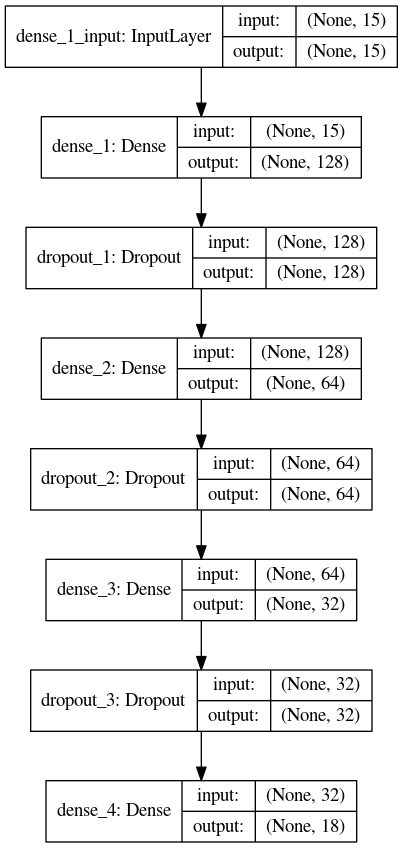

In [15]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(Y_train_one_hot.shape[1],   activation='softmax')])

print(dense_model1.summary())
plot_model(dense_model1, to_file='dense1.png', show_shapes=True)
Image.open('dense1.png')

## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [16]:
dense_model1.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [17]:
history = dense_model1.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_data=(X_test, Y_test_one_hot), verbose=2,shuffle=False, use_multiprocessing=True);

Train on 2479 samples, validate on 276 samples
Epoch 1/25
 - 1s - loss: 2.7960 - accuracy: 0.1077 - val_loss: 2.6810 - val_accuracy: 0.1413
Epoch 2/25
 - 1s - loss: 2.5613 - accuracy: 0.1787 - val_loss: 2.4152 - val_accuracy: 0.2029
Epoch 3/25
 - 1s - loss: 2.4569 - accuracy: 0.1960 - val_loss: 2.3654 - val_accuracy: 0.2464
Epoch 4/25
 - 1s - loss: 2.4073 - accuracy: 0.2025 - val_loss: 2.3493 - val_accuracy: 0.2609
Epoch 5/25
 - 1s - loss: 2.3872 - accuracy: 0.2114 - val_loss: 2.3038 - val_accuracy: 0.2645
Epoch 6/25
 - 1s - loss: 2.3579 - accuracy: 0.2098 - val_loss: 2.3024 - val_accuracy: 0.2754
Epoch 7/25
 - 1s - loss: 2.3442 - accuracy: 0.2146 - val_loss: 2.2759 - val_accuracy: 0.2754
Epoch 8/25
 - 1s - loss: 2.3195 - accuracy: 0.2287 - val_loss: 2.2700 - val_accuracy: 0.2717
Epoch 9/25
 - 1s - loss: 2.3142 - accuracy: 0.2263 - val_loss: 2.2515 - val_accuracy: 0.2754
Epoch 10/25
 - 1s - loss: 2.3032 - accuracy: 0.2356 - val_loss: 2.2617 - val_accuracy: 0.2754
Epoch 11/25
 - 1s - lo

## Visualizing Training Stage Results

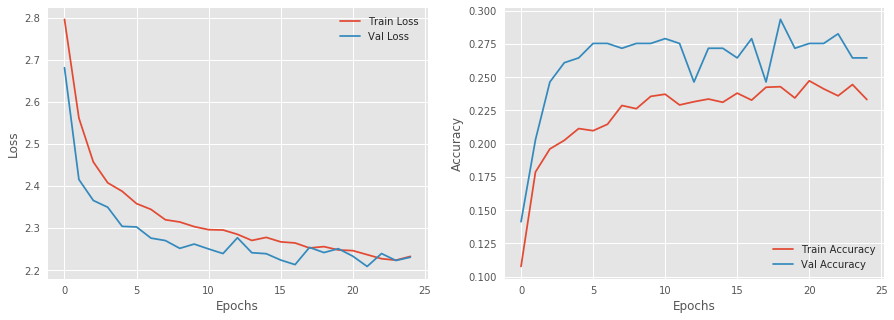

In [18]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [19]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.264


In [20]:
predictions_full = dense_model1.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.245


In [21]:
softmax_vals = dense_model1.predict_proba(X)
#print(softmax_vals[:,i].shape)
df1 = copy.deepcopy(data)
df1['Preds'] = predictions_full
for i, col in enumerate(encoder.classes_):
    df1[col + '_softmax'] = softmax_vals[:,i]

## Printing/Plotting Classification Metrics

In [1]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    #wr_mlp, vals, mdd_mlp = WR(actual_rets_test,predictions), ARR(actual_rets_test,predictions), MDD(actual_rets_test,predictions)
    #arr_mlp, asr_mlp=vals[0], vals[1]
    #results.append([model_name, wr_mlp, arr_mlp, asr_mlp, mdd_mlp])

    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('DenseNetv1', actual_rets_test, Y_test, predictions)

NameError: name 'actual_rets_test' is not defined

## Visualising Weights
Below we are visualising average weights of first layer which has same shape as that of number of features.

Layer : Dense : Weights : (15, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 18)
Layer : Dense : Bias : (18,)


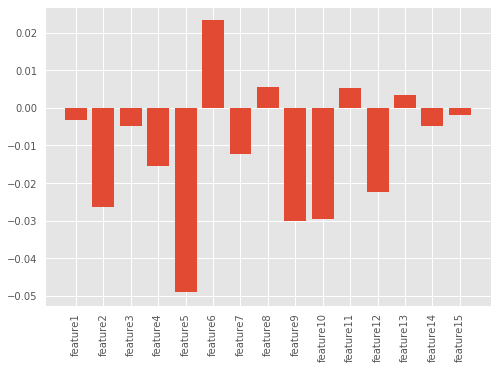

In [23]:
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

print_weights_per_layer(dense_model1)

dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              32768     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

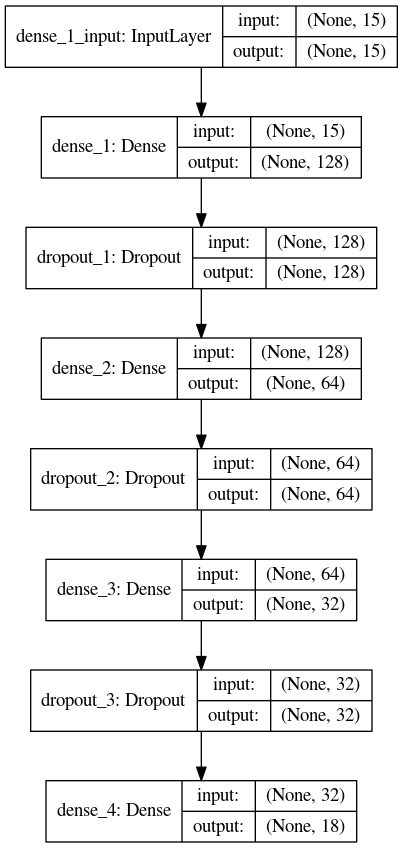

In [24]:
dense_model2 = Sequential([ 
                     Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.3),
                     Dense(1024,  activation='relu'),
                     Dropout(0.3),
                     Dense(512,  activation='relu'),
                     Dropout(0.3),
                     Dense(256,  activation='relu'),
                     Dropout(0.3),
                     Dense(128,  activation='relu'),
                     Dropout(0.3),
                     Dense(64,  activation='relu'),
                     Dropout(0.3),
                     Dense(32,  activation='relu'),
                     Dropout(0.3),
                     Dense(Y_train_one_hot.shape[1],   activation='softmax')])

print(dense_model2.summary())
plot_model(dense_model1, to_file='dense2.png', show_shapes=True)
Image.open('dense2.png')

## Compiling Model

In [25]:
dense_model2.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [26]:
history = dense_model2.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_data=(X_test, Y_test_one_hot), verbose=2,shuffle=False, use_multiprocessing=True);

Train on 2479 samples, validate on 276 samples
Epoch 1/25
 - 10s - loss: 2.8303 - accuracy: 0.1049 - val_loss: 2.8681 - val_accuracy: 0.0616
Epoch 2/25
 - 9s - loss: 2.7234 - accuracy: 0.1234 - val_loss: 2.5099 - val_accuracy: 0.2283
Epoch 3/25
 - 10s - loss: 2.5878 - accuracy: 0.1682 - val_loss: 2.5097 - val_accuracy: 0.2283
Epoch 4/25
 - 9s - loss: 2.5375 - accuracy: 0.1791 - val_loss: 2.4732 - val_accuracy: 0.2210
Epoch 5/25
 - 9s - loss: 2.4721 - accuracy: 0.1815 - val_loss: 2.4503 - val_accuracy: 0.2210
Epoch 6/25
 - 9s - loss: 2.4591 - accuracy: 0.1900 - val_loss: 2.5012 - val_accuracy: 0.2246
Epoch 7/25
 - 9s - loss: 2.4183 - accuracy: 0.1876 - val_loss: 2.3873 - val_accuracy: 0.2500
Epoch 8/25
 - 9s - loss: 2.3981 - accuracy: 0.2110 - val_loss: 2.3900 - val_accuracy: 0.2572
Epoch 9/25
 - 9s - loss: 2.4124 - accuracy: 0.2033 - val_loss: 2.3375 - val_accuracy: 0.2899
Epoch 10/25
 - 9s - loss: 2.3967 - accuracy: 0.2207 - val_loss: 2.3168 - val_accuracy: 0.2609
Epoch 11/25
 - 9s - 

## Visualising Training Stage Results

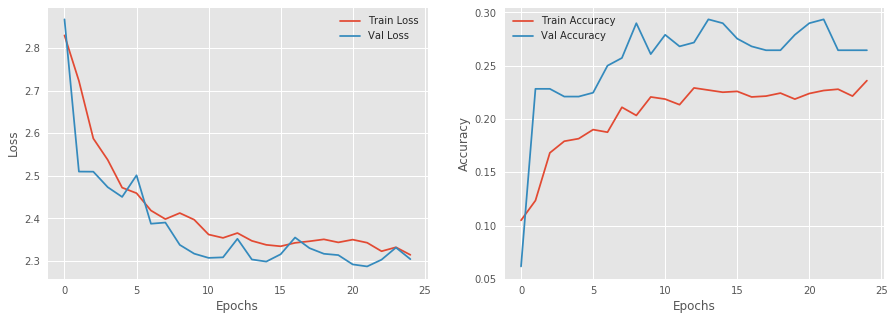

In [27]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [28]:
predictions = dense_model2.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.264


In [29]:
predictions_full = dense_model2.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))


Accuracy : 0.233


In [30]:
softmax_vals = dense_model2.predict_proba(X)
#print(softmax_vals[:,i].shape)
df2 = copy.deepcopy(data)
df2['Preds'] = predictions_full
for i, col in enumerate(encoder.classes_):
    df2[col + '_softmax'] = softmax_vals[:,i]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.53      0.84      0.65        32
           1       0.15      0.59      0.24        17
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.08      0.12      0.10        17
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        16
           9       0.19      0.35      0.25        17
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        17
          15       0.10      0.14      0.12        21
          16       0.00      0.00      0.00        18
 

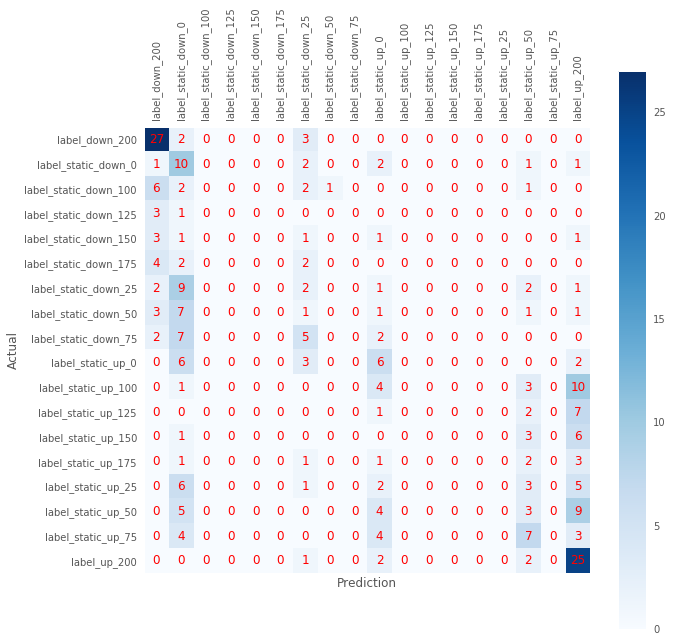

In [31]:
print_plot_metrics('DenseNetv2', actual_rets_test, Y_test, predictions)

Layer : Dense : Weights : (15, 2048)
Layer : Dense : Bias : (2048,)
Layer : Dense : Weights : (2048, 1024)
Layer : Dense : Bias : (1024,)
Layer : Dense : Weights : (1024, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 18)
Layer : Dense : Bias : (18,)


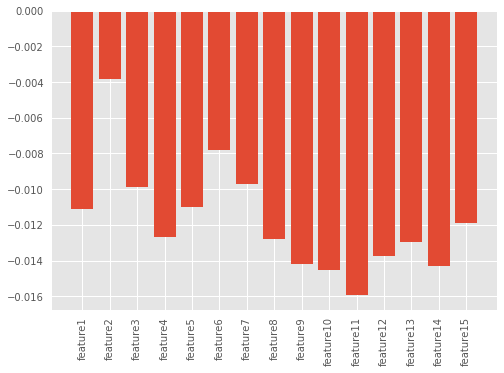

In [32]:
print_weights_per_layer(dense_model2)

dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [33]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values
Y_one_hot = np_utils.to_categorical(data['encoded_label'].values)

ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Actual Data Size : ', X.shape, Y.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
#print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50
X_train, Y_train = prepare_dataset(X_train, Y_train, look_back)
X_test, Y_test = prepare_dataset(X_test, Y_test, look_back)

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

X_train, Y_train_one_hot = prepare_dataset(X_train, Y_train_one_hot, look_back)
X_test, Y_test_one_hot = prepare_dataset(X_test, Y_test_one_hot, look_back)

X_new, Y_new = prepare_dataset(X, Y, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train_one_hot.shape, X_test.shape, Y_test_one_hot.shape)

Actual Data Size :  (2755, 15) (2755,)
Train/Test Sizes :  (2479, 15) (276, 15) (2479,) (276,)
Actual Return Sizes :  (276,)
Modified Data Size :  (2705, 50, 15) (2705,)
Train/Test Sizes Modified (2429, 50, 15) (2429,) (226, 50, 15) (226,)
Train/Test Sizes Modified (2429, 50, 15) (2429, 18) (226, 50, 15) (226, 18)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 18)                918       
Total params: 14,118
Trainable params: 14,118
Non-trainable params: 0
_________________________________________________________________
None


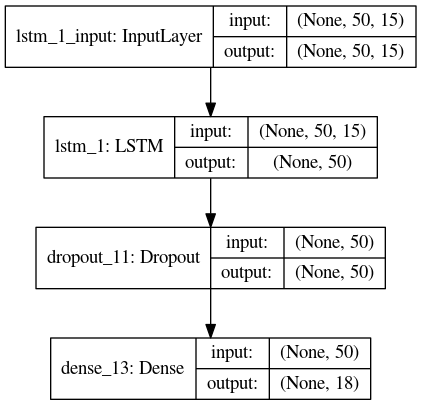

In [34]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.3),
                        Dense(Y_train_one_hot.shape[1], activation='softmax')                        
                        ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif1.png', show_shapes=True)
Image.open('lstm_classif1.png')

## Compiling Model

In [35]:
lstm_classif.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [36]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=8, validation_split=0.1, verbose=2, shuffle=False)

Train on 2186 samples, validate on 243 samples
Epoch 1/30
 - 7s - loss: 2.8347 - accuracy: 0.0956 - val_loss: 2.7944 - val_accuracy: 0.1152
Epoch 2/30
 - 7s - loss: 2.8232 - accuracy: 0.0837 - val_loss: 2.7850 - val_accuracy: 0.1111
Epoch 3/30
 - 7s - loss: 2.8155 - accuracy: 0.0878 - val_loss: 2.7840 - val_accuracy: 0.1111
Epoch 4/30
 - 7s - loss: 2.8046 - accuracy: 0.0942 - val_loss: 2.7822 - val_accuracy: 0.1111
Epoch 5/30
 - 7s - loss: 2.8045 - accuracy: 0.1020 - val_loss: 2.7836 - val_accuracy: 0.1152
Epoch 6/30
 - 6s - loss: 2.7968 - accuracy: 0.1011 - val_loss: 2.7805 - val_accuracy: 0.1193
Epoch 7/30
 - 6s - loss: 2.7970 - accuracy: 0.1016 - val_loss: 2.7852 - val_accuracy: 0.1152
Epoch 8/30
 - 7s - loss: 2.7955 - accuracy: 0.1061 - val_loss: 2.7763 - val_accuracy: 0.1193
Epoch 9/30
 - 7s - loss: 2.7948 - accuracy: 0.1006 - val_loss: 2.7808 - val_accuracy: 0.1152
Epoch 10/30
 - 7s - loss: 2.7965 - accuracy: 0.1075 - val_loss: 2.7852 - val_accuracy: 0.1235
Epoch 11/30
 - 7s - lo

## Visualizing Training Stage Results

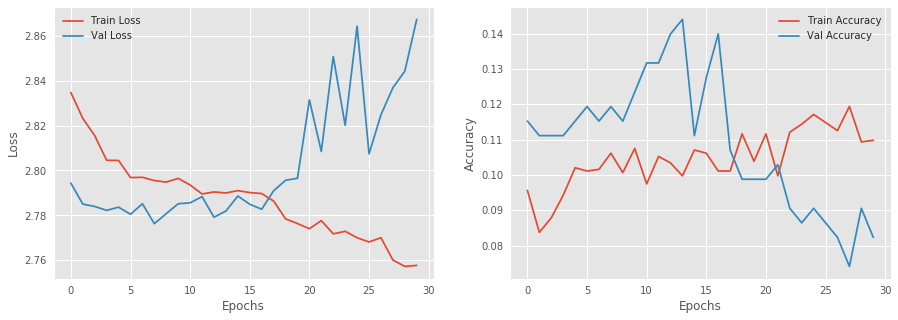

In [37]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [38]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.106


In [39]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.107


In [40]:
softmax_vals = lstm_classif.predict_proba(X_new)
#print(softmax_vals[:,i].shape)
df3 = copy.deepcopy(data)
df3['Preds'] = np.hstack((['label_down_200']*50, predictions_full))
for i, col in enumerate(encoder.classes_):
    df3[col + '_softmax'] = np.hstack((np.zeros(50), softmax_vals[:,i]))

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.24      0.48      0.32        27
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         8
          14       0.06      0.85      0.12        13
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        12
 

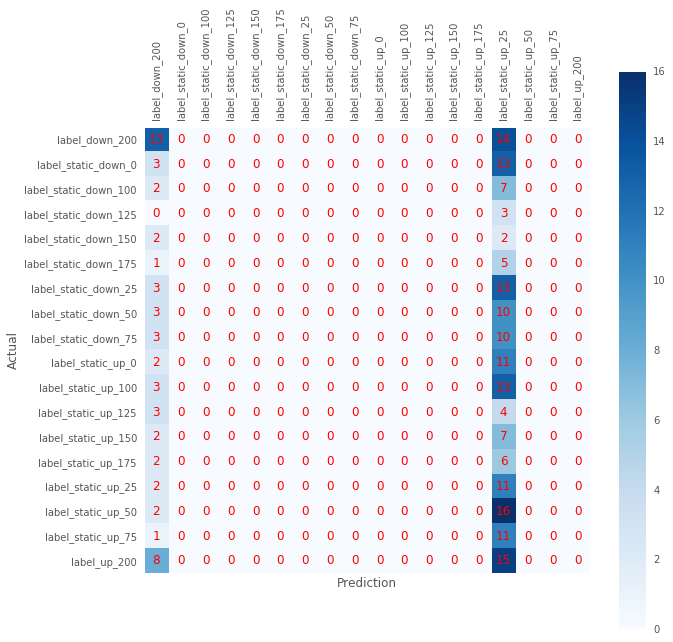

In [41]:
print_plot_metrics('LSTMv1', actual_rets_test, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


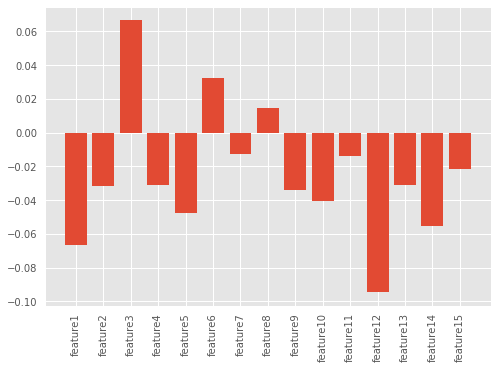

In [42]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 30)            5520      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_14 (Dense)             (None, 18)                558       
Total params: 20,718
Trainable params: 20,718
Non-trainable params: 0
_________________________________________________________________
None


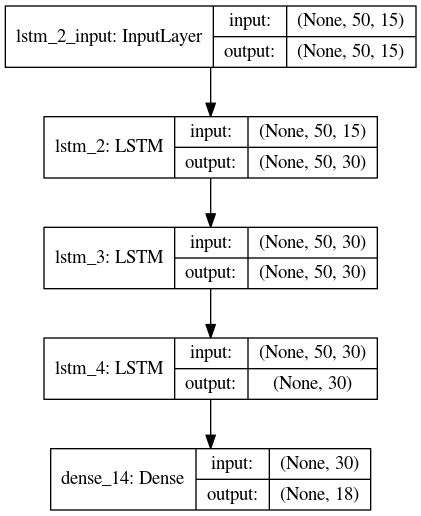

In [43]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_one_hot.shape[1], activation='softmax')
                ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif2.png', show_shapes=True)
Image.open('lstm_classif2.png')

## Compiling Model

In [44]:
lstm_classif.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [45]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=16, validation_split=0.1, verbose=2, shuffle=False)

Train on 2186 samples, validate on 243 samples
Epoch 1/30
 - 10s - loss: 2.8369 - accuracy: 0.0796 - val_loss: 2.8049 - val_accuracy: 0.1111
Epoch 2/30
 - 9s - loss: 2.8154 - accuracy: 0.0819 - val_loss: 2.8023 - val_accuracy: 0.1111
Epoch 3/30
 - 9s - loss: 2.8131 - accuracy: 0.0828 - val_loss: 2.8015 - val_accuracy: 0.1029
Epoch 4/30
 - 9s - loss: 2.8113 - accuracy: 0.0828 - val_loss: 2.8024 - val_accuracy: 0.0741
Epoch 5/30
 - 9s - loss: 2.8101 - accuracy: 0.0855 - val_loss: 2.8064 - val_accuracy: 0.0823
Epoch 6/30
 - 9s - loss: 2.8093 - accuracy: 0.0855 - val_loss: 2.8073 - val_accuracy: 0.0864
Epoch 7/30
 - 9s - loss: 2.8069 - accuracy: 0.0910 - val_loss: 2.8078 - val_accuracy: 0.0864
Epoch 8/30
 - 9s - loss: 2.8041 - accuracy: 0.0942 - val_loss: 2.8097 - val_accuracy: 0.0905
Epoch 9/30
 - 9s - loss: 2.8016 - accuracy: 0.0924 - val_loss: 2.8159 - val_accuracy: 0.1193
Epoch 10/30
 - 9s - loss: 2.8026 - accuracy: 0.0952 - val_loss: 2.8211 - val_accuracy: 0.0988
Epoch 11/30
 - 9s - l

## Visualizing Training Stage Results

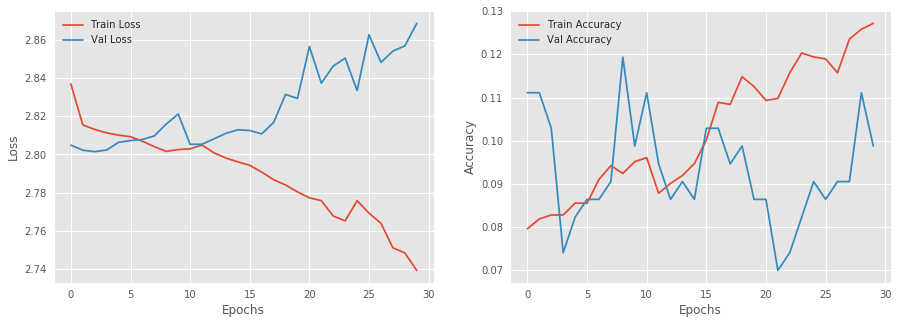

In [46]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [47]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.124


In [48]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.129


In [49]:
softmax_vals = lstm_classif.predict_proba(X_new)
#print(softmax_vals[:,i].shape)
df4 = copy.deepcopy(data)
df4['Preds'] = np.hstack((['label_down_200']*50, predictions_full))
for i, col in enumerate(encoder.classes_):
    df4[col + '_softmax'] = np.hstack((np.zeros(50), softmax_vals[:,i]))

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.16      0.81      0.26        27
           1       0.03      0.06      0.04        16
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        13
           9       0.10      0.23      0.14        13
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        13
          15       0.11      0.06      0.07        18
          16       0.00      0.00      0.00        12
 

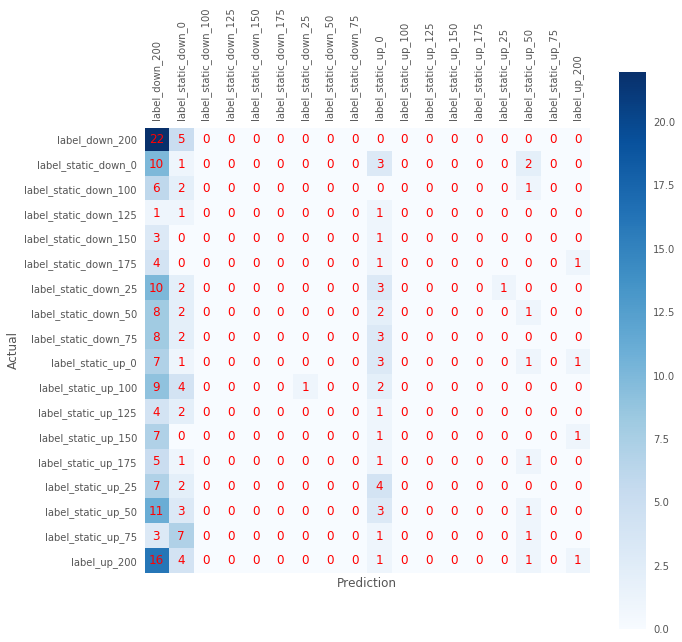

In [50]:
print_plot_metrics('LSTMv2' , actual_rets_test, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


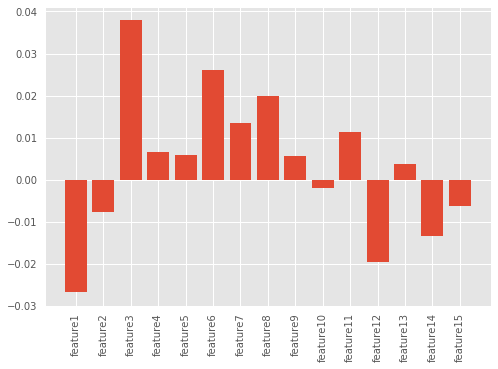

In [51]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

In [52]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('DenseNetv1',df1), ('DenseNetv2',df2), ('LSTMv1', df3), ('LSTMv2', df4)]:
        df1.to_excel(writer, sheet_name= sheet_name)

In [53]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx